# SVM Implementation with Kernels

In [1]:
from matplotlib import pyplot as plt
import seaborn as sns
import torch
import numpy as np
from sklearn.datasets import make_circles
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

### Make Circle DataSet

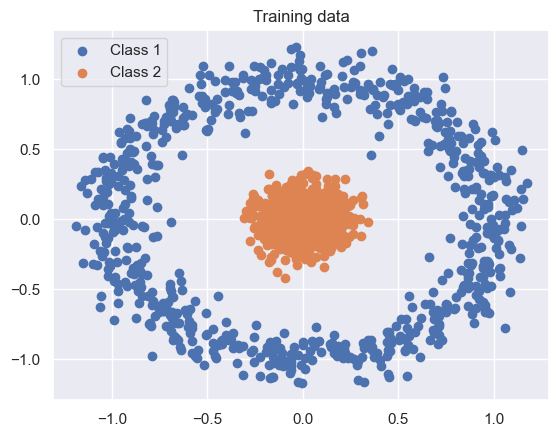

In [4]:
sns.set()
np.random.seed(0)

x, y = make_circles(1500, factor=0.1, noise=0.1)
y[np.where(y==0)] = -1

fig, ax = plt.subplots()
ax.scatter(x[np.where(y==-1),0], x[np.where(y==-1),1], label='Class 1')
#ax.scatter(x[np.where(y==0),0], x[np.where(y==0),1], label='Class 1')
ax.scatter(x[np.where(y==1),0], x[np.where(y==1),1], label='Class 2')
ax.set_title('Training data')
ax.legend();

In [5]:
x, X_test, y, y_test = train_test_split(x, y, test_size=250, random_state=1)
x, X_val, y, y_val = train_test_split(x, y, test_size=250, random_state=1)
x = torch.FloatTensor(x)
y = torch.FloatTensor(y)
X_test = torch.FloatTensor(X_test)
y_test = torch.FloatTensor(y_test)
X_val = torch.FloatTensor(X_val)
y_val = torch.FloatTensor(y_val)

In [3]:
def hingeLoss(x, y):
    return torch.max(torch.zeros_like(y), 1-y*x).mean()

class SVM(torch.nn.Module):
    def __init__(self, X,kernel='linear',gamma=1.0,gammaGrad=True,p=2):
        super().__init__()
        assert kernel in ['linear', 'rbf', 'poly']
        self.X = X
        
        if kernel == 'linear':
            self._kernel = self.linear
            self._num_c = self.X.shape[1]
        elif kernel == 'rbf':
            self._kernel = self.rbf
            self._num_c = x.size(0)
            self._gamma = torch.nn.Parameter(torch.FloatTensor([gamma]),
                                             requires_grad=gammaGrad)
        
        elif kernel == 'poly':
            self._p=p
            self._kernel = self.poly
            self._num_c = x.size(0) 
           
        else:
            assert False
            
        self._w = torch.nn.Linear(in_features=self._num_c, out_features=1)

    def rbf(self, x, gamma=1):
        y = self.X.repeat(x.size(0), 1, 1)
        return torch.exp(-self._gamma*((x[:,None]-y)**2).sum(dim=2))

    def poly(self, x, c=1):
        y = self.X.repeat(x.size(0), 1, 1)
        return ((x@(self.X.T))+c) ** self._p     
    
    @staticmethod
    def linear(x):
        return x

    def forward(self, x):
        y = self._kernel(x)
        y = self._w(y)
        return y
    def train(self,x,y,X_val,y_val,epochs=1000,lambda_reg=0):
        valat=epochs/10
        optim=torch.optim.SGD(self.parameters(),lr=0.01)
        for i in range(epochs):
            optim.zero_grad()
            pred=self(x)
            loss=hingeLoss(pred,y.unsqueeze(1))+lambda_reg*torch.norm(self._w.weight,1)
            loss.backward()
            optim.step()
            ypred=self(X_val).detach()
            ypred=ypred.transpose(1,0).reshape(y_val.shape).numpy()
            ypred[np.where(ypred<0)]=-1
            ypred[np.where(ypred>=0)]=1
            if i%valat==0:
                print("Validation Accuracy at epoch",i,":",accuracy_score(y_val,ypred))
        print("Training Loss is :",loss.item())
    def test(self,x_test,y_test):
        ypred=self(x_test).detach()
        ypred=ypred.transpose(1,0).reshape(y_test.shape).numpy()
        ypred[np.where(ypred<0)]=-1
        ypred[np.where(ypred>=0)]=1
        print("Test Accuracy:",accuracy_score(y_test,ypred))


In [6]:
linSVM=SVM(x,kernel='linear')
linSVM.train(x,y,X_val,y_val)
linSVM.test(X_test,y_test)

Validation Accuracy at epoch 0 : 0.676
Validation Accuracy at epoch 100 : 0.672
Validation Accuracy at epoch 200 : 0.664
Validation Accuracy at epoch 300 : 0.664
Validation Accuracy at epoch 400 : 0.664
Validation Accuracy at epoch 500 : 0.668
Validation Accuracy at epoch 600 : 0.66
Validation Accuracy at epoch 700 : 0.664
Validation Accuracy at epoch 800 : 0.66
Validation Accuracy at epoch 900 : 0.668
Training Loss is : 0.9926028847694397
Test Accuracy: 0.688


In [7]:
polySVM=SVM(x,kernel='poly',p=2)
polySVM.train(x,y,X_val,y_val)
polySVM.test(X_test,y_test)

Validation Accuracy at epoch 0 : 0.52
Validation Accuracy at epoch 100 : 1.0
Validation Accuracy at epoch 200 : 1.0
Validation Accuracy at epoch 300 : 1.0
Validation Accuracy at epoch 400 : 1.0
Validation Accuracy at epoch 500 : 1.0
Validation Accuracy at epoch 600 : 1.0
Validation Accuracy at epoch 700 : 1.0
Validation Accuracy at epoch 800 : 1.0
Validation Accuracy at epoch 900 : 1.0
Training Loss is : 0.0003671780286822468
Test Accuracy: 1.0


In [8]:
rbfSVM=SVM(x,kernel='rbf')
rbfSVM.train(x,y,X_val,y_val)
rbfSVM.test(X_test,y_test)

Validation Accuracy at epoch 0 : 0.48
Validation Accuracy at epoch 100 : 1.0
Validation Accuracy at epoch 200 : 1.0
Validation Accuracy at epoch 300 : 1.0
Validation Accuracy at epoch 400 : 1.0
Validation Accuracy at epoch 500 : 1.0
Validation Accuracy at epoch 600 : 1.0
Validation Accuracy at epoch 700 : 1.0
Validation Accuracy at epoch 800 : 1.0
Validation Accuracy at epoch 900 : 1.0
Training Loss is : 0.0016301448922604322
Test Accuracy: 1.0


In [9]:
def plotSVM(model_linear,x,y,title):
    grid_x, grid_y = torch.meshgrid(torch.arange(x.min()*1.1, x.max()*1.1, step=0.1),
                                    torch.arange(x.min()*1.1, x.max()*1.1, step=0.1))
    x_test_grid = torch.stack((grid_x, grid_y)).reshape(2, -1).transpose(1,0)

    y_test_linear = model_linear(x_test_grid).detach()

    y_test_linear = y_test_linear.transpose(1,0).reshape(grid_x.shape).numpy()
    



    fig, ax = plt.subplots(1,1, figsize=(10,10))

    cs0 = ax.contourf(grid_x.numpy(), grid_y.numpy(), y_test_linear,cmap="Blues")
    ax.contour(cs0, '--', levels=[0], colors='tab:green', linewidths=2)

    ax.plot(np.nan, label='decision boundary', color='tab:green')
    ax.scatter(x[np.where(y==-1),0], x[np.where(y==-1),1])

    ax.scatter(x[np.where(y==1),0], x[np.where(y==1),1])
    ax.legend()
    ax.set_title(title)


/Users/anudeep/Library/Python/3.9/lib/python/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3484.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/var/folders/kr/tmv0s2jx5nzbfv914ndj8tq00000gn/T/ipykernel_46121/1474882802.py:19: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:248.)
  ax.scatter(x[np.where(y==-1),0], x[np.where(y==-1),1])


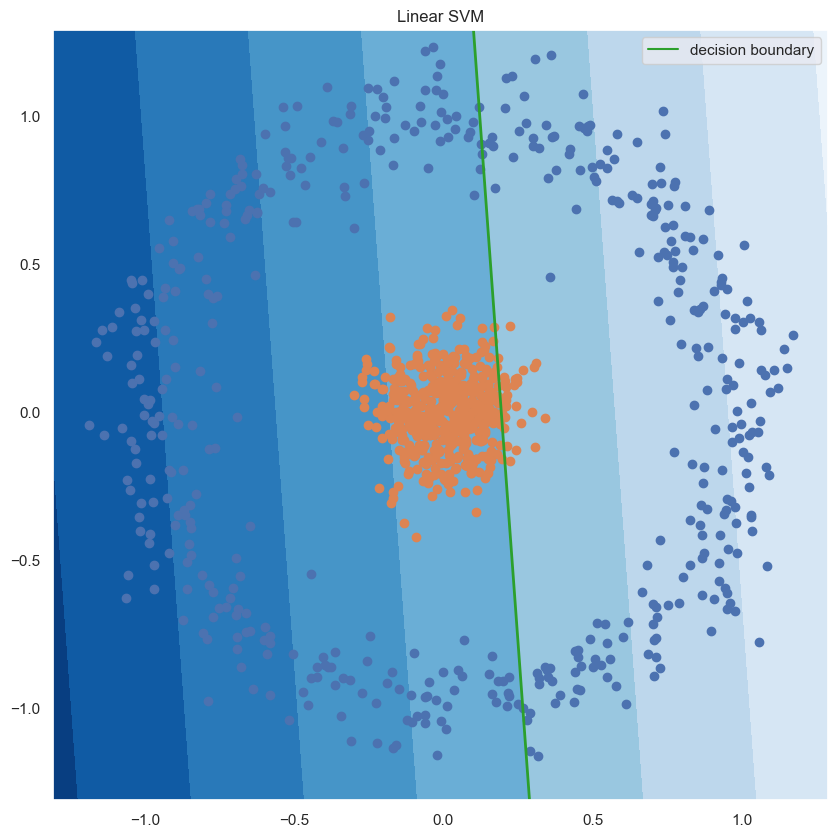

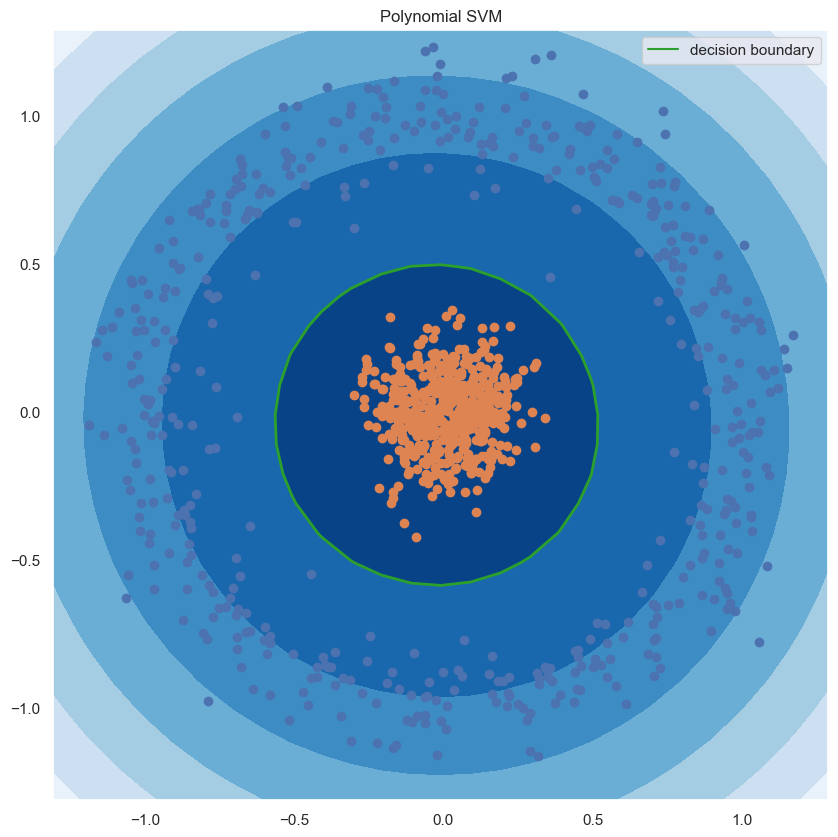

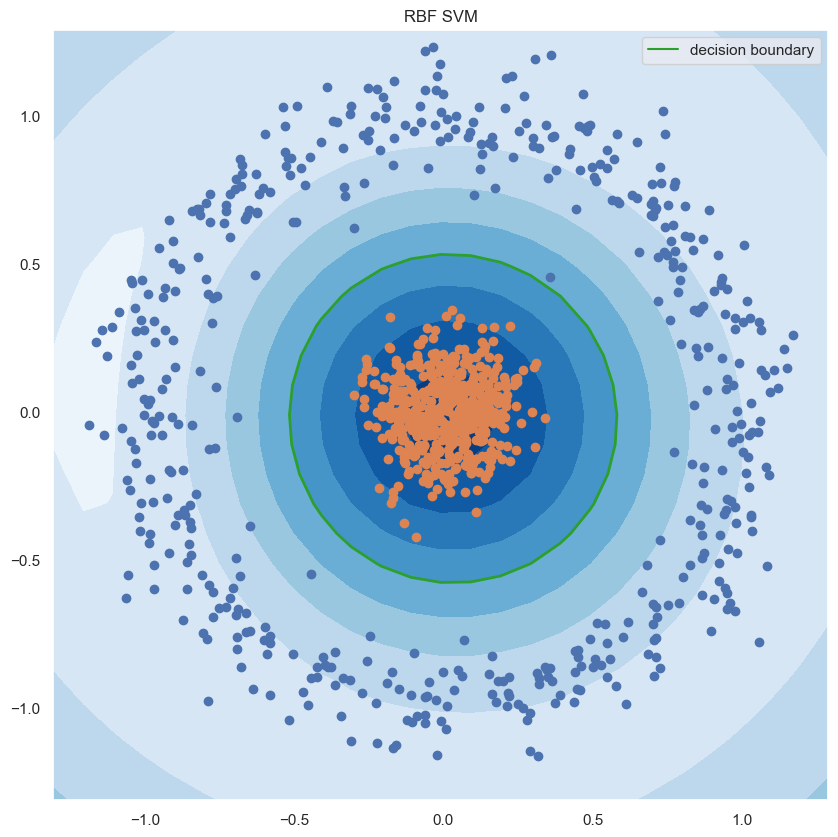

In [10]:
plotSVM(linSVM,x,y,'Linear SVM')
plotSVM(polySVM,x,y,'Polynomial SVM')
plotSVM(rbfSVM,x,y,'RBF SVM')

## Breast Cancer DataSet

In [11]:
from sklearn.datasets import load_breast_cancer
from sklearn import preprocessing
data = load_breast_cancer()
x, y = data.data, data.target
x = preprocessing.normalize(x)
print(x.shape)

x, X_test, y, y_test = train_test_split(x, y, test_size=150, random_state=2)
x, X_val, y, y_val = train_test_split(x, y, test_size=150, random_state=1)
x = torch.FloatTensor(x)
y = torch.FloatTensor(2*y-1)
X_test = torch.FloatTensor(X_test)
y_test = torch.FloatTensor(2*y_test-1)
X_val = torch.FloatTensor(X_val)
y_val = torch.FloatTensor(2*y_val-1)

(569, 30)


In [12]:
linSVM=SVM(x,kernel='linear')
linSVM.train(x,y,X_val,y_val,epochs=10000)
linSVM.test(X_test,y_test)

Validation Accuracy at epoch 0 : 0.4066666666666667
Validation Accuracy at epoch 1000 : 0.5933333333333334
Validation Accuracy at epoch 2000 : 0.5933333333333334
Validation Accuracy at epoch 3000 : 0.5933333333333334
Validation Accuracy at epoch 4000 : 0.5933333333333334
Validation Accuracy at epoch 5000 : 0.5933333333333334
Validation Accuracy at epoch 6000 : 0.5933333333333334
Validation Accuracy at epoch 7000 : 0.5933333333333334
Validation Accuracy at epoch 8000 : 0.5933333333333334
Validation Accuracy at epoch 9000 : 0.5933333333333334
Training Loss is : 0.6222411394119263
Test Accuracy: 0.6066666666666667


In [13]:
polySVM=SVM(x,kernel='poly',p=2)
polySVM.train(x,y,X_val,y_val,epochs=10000)
polySVM.test(X_test,y_test)

Validation Accuracy at epoch 0 : 0.5933333333333334
Validation Accuracy at epoch 1000 : 0.4066666666666667
Validation Accuracy at epoch 2000 : 0.5933333333333334
Validation Accuracy at epoch 3000 : 0.6066666666666667
Validation Accuracy at epoch 4000 : 0.66
Validation Accuracy at epoch 5000 : 0.4066666666666667
Validation Accuracy at epoch 6000 : 0.5933333333333334
Validation Accuracy at epoch 7000 : 0.6666666666666666
Validation Accuracy at epoch 8000 : 0.4066666666666667
Validation Accuracy at epoch 9000 : 0.5933333333333334
Training Loss is : 6.537065029144287
Test Accuracy: 0.6066666666666667


In [17]:
polySVM=SVM(x,kernel='poly',p=4)
polySVM.train(x,y,X_val,y_val,epochs=10000)
polySVM.test(X_test,y_test)

Validation Accuracy at epoch 0 : 0.4066666666666667
Validation Accuracy at epoch 1000 : 0.5933333333333334
Validation Accuracy at epoch 2000 : 0.6333333333333333
Validation Accuracy at epoch 3000 : 0.4066666666666667
Validation Accuracy at epoch 4000 : 0.5933333333333334
Validation Accuracy at epoch 5000 : 0.6533333333333333
Validation Accuracy at epoch 6000 : 0.5266666666666666
Validation Accuracy at epoch 7000 : 0.8866666666666667
Validation Accuracy at epoch 8000 : 0.9066666666666666
Validation Accuracy at epoch 9000 : 0.9066666666666666
Training Loss is : 2.662261724472046
Test Accuracy: 0.9066666666666666


In [15]:
rbfSVM=SVM(x,kernel='rbf')
rbfSVM.train(x,y,X_val,y_val,epochs=10000)
rbfSVM.test(X_test,y_test)

Validation Accuracy at epoch 0 : 0.5933333333333334
Validation Accuracy at epoch 1000 : 0.5933333333333334
Validation Accuracy at epoch 2000 : 0.6
Validation Accuracy at epoch 3000 : 0.8
Validation Accuracy at epoch 4000 : 0.88
Validation Accuracy at epoch 5000 : 0.88
Validation Accuracy at epoch 6000 : 0.9
Validation Accuracy at epoch 7000 : 0.9066666666666666
Validation Accuracy at epoch 8000 : 0.9066666666666666
Validation Accuracy at epoch 9000 : 0.9066666666666666
Training Loss is : 0.2626849412918091
Test Accuracy: 0.9066666666666666


## Adding L1 Regularizartion

In [124]:
print("===================Linear=======================")
linSVM=SVM(x,kernel='linear')
linSVM.train(x,y,X_val,y_val,epochs=10000,lambda_reg=0.01)
linSVM.test(X_test,y_test)


===================Linear=======================
Validation Accuracy at epoch 0 : 0.08
Validation Accuracy at epoch 1000 : 0.5933333333333334
Validation Accuracy at epoch 2000 : 0.5933333333333334
Validation Accuracy at epoch 3000 : 0.5933333333333334
Validation Accuracy at epoch 4000 : 0.5933333333333334
Validation Accuracy at epoch 5000 : 0.5933333333333334
Validation Accuracy at epoch 6000 : 0.5933333333333334
Validation Accuracy at epoch 7000 : 0.5933333333333334
Validation Accuracy at epoch 8000 : 0.5933333333333334
Validation Accuracy at epoch 9000 : 0.5933333333333334
Training Loss is : 0.6807504892349243
Test Accuracy: 0.6066666666666667


In [22]:
print("===================Polynomial====================")
polySVM=SVM(x,kernel='poly',p=4)
polySVM.train(x,y,X_val,y_val,epochs=10000,lambda_reg=0.01)
polySVM.test(X_test,y_test)

===================Polynomial====================
Validation Accuracy at epoch 0 : 0.5933333333333334
Validation Accuracy at epoch 1000 : 0.4066666666666667
Validation Accuracy at epoch 2000 : 0.5933333333333334
Validation Accuracy at epoch 3000 : 0.6333333333333333
Validation Accuracy at epoch 4000 : 0.4066666666666667
Validation Accuracy at epoch 5000 : 0.5933333333333334
Validation Accuracy at epoch 6000 : 0.64
Validation Accuracy at epoch 7000 : 0.4866666666666667
Validation Accuracy at epoch 8000 : 0.9
Validation Accuracy at epoch 9000 : 0.7733333333333333
Training Loss is : 7.140440940856934
Test Accuracy: 0.9066666666666666


In [34]:
print("===================RBF===========================")
rbfSVM=SVM(x,kernel='rbf')
rbfSVM.train(x,y,X_val,y_val,epochs=10000,lambda_reg=0.01)
rbfSVM.test(X_test,y_test)

===================RBF===========================
Validation Accuracy at epoch 0 : 0.5933333333333334
Validation Accuracy at epoch 1000 : 0.5933333333333334
Validation Accuracy at epoch 2000 : 0.5933333333333334
Validation Accuracy at epoch 3000 : 0.5933333333333334
Validation Accuracy at epoch 4000 : 0.5933333333333334
Validation Accuracy at epoch 5000 : 0.5933333333333334
Validation Accuracy at epoch 6000 : 0.5933333333333334
Validation Accuracy at epoch 7000 : 0.5933333333333334
Validation Accuracy at epoch 8000 : 0.5933333333333334
Validation Accuracy at epoch 9000 : 0.6066666666666667
Training Loss is : 0.887923002243042
Test Accuracy: 0.6066666666666667


## Important Features

In [160]:
w=(linSVM._w.weight)/0.01
w=w.detach().numpy()
print(w[0][np.where(w>0.01)[1]])
data.feature_names[np.where(w>0.01)[1]]


[18.05635  64.9483   15.613797]


array(['mean perimeter', 'mean area', 'worst perimeter'], dtype='<U23')

In [153]:
for i in range(30):
    print(w[0][i],":",data.feature_names[i])

-0.0065172506 : mean radius
-0.0035223518 : mean texture
18.05635 : mean perimeter
64.9483 : mean area
-0.0029732299 : mean smoothness
0.0010736207 : mean compactness
-0.0067041307 : mean concavity
-0.0011597722 : mean concave points
-0.0042800168 : mean symmetry
0.0021766732 : mean fractal dimension
0.002176052 : radius error
-0.0037289567 : texture error
0.0020942076 : perimeter error
0.006773497 : area error
0.0075961174 : smoothness error
0.006457612 : compactness error
0.0072572697 : concavity error
-0.009620716 : concave points error
-0.0075083263 : symmetry error
0.007593509 : fractal dimension error
0.0039155195 : worst radius
0.00853531 : worst texture
15.613797 : worst perimeter
-21.303122 : worst area
0.0060244 : worst smoothness
0.0043241307 : worst compactness
0.0042090076 : worst concavity
0.0024140528 : worst concave points
-0.0045974907 : worst symmetry
-0.006790399 : worst fractal dimension
